## Effects of MAM Pacific SST and uwind on JJA Borneo rainfall.

Here we investigate the effects of sea surface temperature over the eastern North Pacific (MAM SST) and zonal wind over the western equatorial Pacific in the boreal spring months (MAM uwind) on mean precipitaion over Indonesian Borneo (BorneoP) in the boreal summer months (JJA).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import os

import iris
import iris.coord_categorisation
import datetime
from iris.time import PartialDateTime

import iris.quickplot as qplt

from iris.pandas import as_cube, as_series, as_data_frame
import cf_units


from scipy import signal
import scipy.stats as stats

import statsmodels.api as sm
import pandas as pd

import copy

import sklearn.linear_model as ML

import statsmodels.api as sm

# Load data means

In [2]:
year_constraint = iris.Constraint(season_year=lambda v: v > 1980 and v <= 2014 )

In [3]:
precip_Borneo = iris.load_cube('Borneo_precip_chirps_mean.nc', 'Climate Hazards group InfraRed Precipitation with Stations')
precip_Borneo = precip_Borneo.extract(year_constraint)

In [4]:
pacific_SST = iris.load_cube('Pacific_sst_mean_Hadley.nc', 'sea_surface_temperature')
pacific_SST = pacific_SST.extract(year_constraint)

In [5]:
pacific_wind = iris.load_cube('Pacific_wind_mean.nc', '100 metre U wind component')
pacific_wind = pacific_wind.extract(year_constraint)

In [8]:
print(np.shape(precip_Borneo),np.shape(pacific_SST),np.shape(pacific_wind))

(34,) (34,) (34,) (34,) (34,)


## Standardize and Detrend

1.0000000000000002
0.9999999999999999
0.9999999999999999


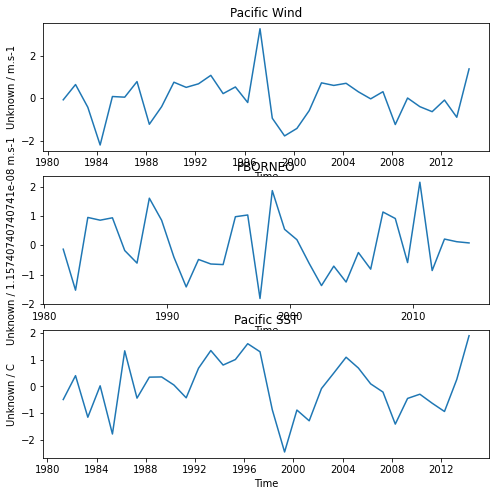

In [9]:
pBorneo_trend = precip_Borneo - signal.detrend(precip_Borneo.data)
pBorneo_det = precip_Borneo  - pBorneo_trend
PBORNEO = (pBorneo_det - np.mean(pBorneo_det.data))/np.std(pBorneo_det.data)

PacificSST_trend = pacific_SST - signal.detrend(pacific_SST.data)
PacificSST_det = pacific_SST  - PacificSST_trend
PACIFIC_SST = (PacificSST_det - np.mean(PacificSST_det.data))/np.std(PacificSST_det.data)

PacificWind_trend = pacific_wind - signal.detrend(pacific_wind.data)
PacificWind_det = pacific_wind  - PacificWind_trend
PACIFIC_WIND = (PacificWind_det - np.mean(PacificWind_det.data))/np.std(PacificWind_det.data)

Vars = {'PacificSST':PACIFIC_SST , 'pBorneo': PBORNEO,  'PacificWind':PACIFIC_WIND}

# To verify whether variables are standardized and detrended
fig = plt.figure(figsize=(8, 8))
plt.subplot(311)
qplt.plot(PACIFIC_WIND)
plt.title('Pacific Wind')
print (np.std (PACIFIC_WIND.data))

plt.subplot(312)
qplt.plot(PBORNEO)
plt.title('PBORNEO')
print (np.std (PBORNEO.data))

plt.subplot(313)
qplt.plot(PACIFIC_SST)
plt.title('Pacific SST')
print (np.std (PACIFIC_SST.data))


# Preliminary Ananlysis
## Bivariate regression/correlation coeff

In [10]:
Reg_PacificWind  = {'PacificWind':0 , 'pBorneo': 0, 'PacificVV500':0, 'PacificSST':0, 'enso':0}
Reg_pBorneo   = {'PacificWind':0 , 'pBorneo': 0, 'PacificVV500':0, 'PacificSST':0, 'enso':0}
Reg_PacificSST = {'PacificWind':0 , 'pBorneo': 0, 'PacificVV500':0, 'PacificSST':0, 'enso':0}

Regs = {'PacificWind':Reg_PacificWind , 'pBorneo': Reg_pBorneo, 'PacificSST': Reg_PacificSST}

Corrs = {'PacificWind':Reg_PacificWind , 'pBorneo': Reg_pBorneo, 'PacificSST': Reg_PacificSST}

In [11]:
for var1 in Vars:
    var1_data = Vars[var1].data
    for var2 in Vars:
        var2_data = Vars[var2].data
        
        res = stats.linregress(var1_data,var2_data)   # Y,X

        Regs[var1][var2]  = np.round(res[0],decimals=3)
        Corrs[var1][var2] = np.round(res[2],decimals=3)
        

In [12]:
for var1 in Vars:
    print(var1,' correlations:')
    print(Corrs[var1])

PacificSST  correlations:
{'PacificWind': 0.565, 'pBorneo': -0.26, 'PacificVV500': 0.325, 'PacificSST': 1.0, 'enso': 0.344}
pBorneo  correlations:
{'PacificWind': -0.586, 'pBorneo': 1.0, 'PacificVV500': -0.891, 'PacificSST': -0.26, 'enso': -0.803}
PacificWind  correlations:
{'PacificWind': 1.0, 'pBorneo': -0.586, 'PacificVV500': 0.696, 'PacificSST': 0.565, 'enso': 0.754}
PacificVV500  correlations:
{'PacificWind': 0.696, 'pBorneo': -0.891, 'PacificVV500': 1.0, 'PacificSST': 0.325, 'enso': 0.807}
enso  correlations:
{'PacificWind': 0.754, 'pBorneo': -0.803, 'PacificVV500': 0.807, 'PacificSST': 0.344, 'enso': 1.0}


In [16]:
for var1 in Vars:
    print('Y = ',var1,' regressed on X:')
    print(Regs[var1])

Y =  PacificSST  regressed on X:
{'PacificWind': 0.58, 'pBorneo': -0.328, 'PacificVV500': 0.403, 'PacificSST': 1.0, 'enso': 0.402}
Y =  pBorneo  regressed on X:
{'PacificWind': -0.611, 'pBorneo': 1.0, 'PacificVV500': -0.942, 'PacificSST': -0.328, 'enso': -0.805}
Y =  PacificWind  regressed on X:
{'PacificWind': 1.0, 'pBorneo': -0.611, 'PacificVV500': 0.714, 'PacificSST': 0.58, 'enso': 0.767}
Y =  PacificVV500  regressed on X:
{'PacificWind': 0.714, 'pBorneo': -0.942, 'PacificVV500': 1.0, 'PacificSST': 0.403, 'enso': 0.837}
Y =  enso  regressed on X:
{'PacificWind': 0.767, 'pBorneo': -0.805, 'PacificVV500': 0.837, 'PacificSST': 0.402, 'enso': 1.0}


# MAM SST --> MAM uwind --> JJA BorneoP

In [13]:
# Determine the effect from Pacific SST --> Pacific wind

Y = Vars['PacificWind'].data
X = np.stack([Vars['PacificSST'].data]).T

#X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.319
Model:                            OLS   Adj. R-squared (uncentered):              0.298
Method:                 Least Squares   F-statistic:                              15.44
Date:                Thu, 02 Sep 2021   Prob (F-statistic):                    0.000412
Time:                        13:55:00   Log-Likelihood:                         -41.721
No. Observations:                  34   AIC:                                      85.44
Df Residuals:                      33   BIC:                                      86.97
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [14]:
# Determine the effect from Pacific SST --> Borneo rainfall

Y = Vars['pBorneo'].data
X = np.stack([Vars['PacificSST'].data]).T

#X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.068
Model:                            OLS   Adj. R-squared (uncentered):              0.039
Method:                 Least Squares   F-statistic:                              2.395
Date:                Thu, 02 Sep 2021   Prob (F-statistic):                       0.131
Time:                        13:56:08   Log-Likelihood:                         -47.053
No. Observations:                  34   AIC:                                      96.11
Df Residuals:                      33   BIC:                                      97.63
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [16]:
# Determine the effect from Pacific wind --> Borneo rainfall

Y = Vars['pBorneo'].data
X = np.stack([Vars['PacificWind'].data]).T

#X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.343
Model:                            OLS   Adj. R-squared (uncentered):              0.323
Method:                 Least Squares   F-statistic:                              17.23
Date:                Thu, 02 Sep 2021   Prob (F-statistic):                    0.000219
Time:                        13:56:39   Log-Likelihood:                         -41.102
No. Observations:                  34   AIC:                                      84.20
Df Residuals:                      33   BIC:                                      85.73
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [18]:
# Modified effect if both SST and wind are included

Y = Vars['pBorneo'].data
X = np.stack([Vars['PacificSST'].data, Vars['PacificWind'].data]).T

model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())

print("effect of Pacific SST on BorneoP=", round(results.params[0],2))

print("effect of Pacific wind on BorneoP =", round(results.params[1],2))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.350
Model:                            OLS   Adj. R-squared (uncentered):              0.310
Method:                 Least Squares   F-statistic:                              8.627
Date:                Thu, 02 Sep 2021   Prob (F-statistic):                     0.00101
Time:                        13:57:08   Log-Likelihood:                         -40.913
No. Observations:                  34   AIC:                                      85.83
Df Residuals:                      32   BIC:                                      88.88
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------